You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# The Poincaré Problem

Selection bias is the hardest problem in statistics because it's almost unavoidable in practice, and once the data have been collected, it's usually not possible to quantify the effect of selection or recover an unbiased estimate of what you are trying to measure.

And because the effect is systematic, not random, it doesn't help to collect more data.
In fact, larger sample sizes make the problem worse, because they give the false impression of precision.

But sometimes, if we are willing to make assumptions about the data generating process, we can use Bayesian methods to infer the effect of selection bias and produce an unbiased estimate.

As an example, let's solve an exercise from [Chapter 7 of *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap07.html). It's based on a fictional anecdote about the mathematician Henri Poincaré:

> Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.
> 
> For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.
> 
> Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.
> 
> To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `k` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?


[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/bread.ipynb).

In [2]:
# install empiricaldist if necessary
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

from utils import decorate, set_pyplot_params

In [5]:
np.random.seed(0)
np.set_printoptions(legacy='1.25')

set_pyplot_params()

The following function generates the maximum of `k` values from a normal distribution with the given parameters, repeated `n` times. 

In [6]:
from scipy.stats import norm

def generate_sample(mu, sigma, k, n):
    return norm(mu, sigma).rvs((k, n)).max(axis=0)

Here are distributions with the same underlying normal distribution and different values of `k`.

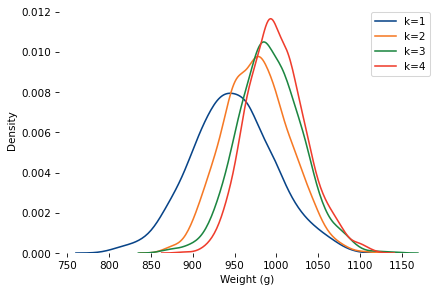

In [7]:
mu_true, sigma_true = 950, 50

for k in range(1, 5):
    sample = generate_sample(mu_true, sigma_true, k, n=1000)
    sns.kdeplot(sample, label=f'k={k}')
    
decorate(xlabel='Weight (g)')
plt.savefig('bread_dist_max.png', dpi=300)

As `k` increases, the mean increases and the standard deviation decreases.

When `k=4`, the mean is close to 1000.
So let's assume the baker hefted four loaves and gave the heaviest to Poincaré.

In [8]:
k_true = 4

sample4 = generate_sample(mu_true, sigma_true, k_true, n=365)
mean, std = sample4.mean(), sample4.std()
mean, std

(1001.9175597523723, 36.27105788650583)

At the end of one year, can we tell the difference between these hypotheses?

* Innocent: The baker actually increased the mean to 1000, and `k=1`.

* Shenanigans: The mean was still 950, but the baker selected with `k=4`.

Here's a sample under the `k=4` scenario, compared to 10 samples with `k=1`.

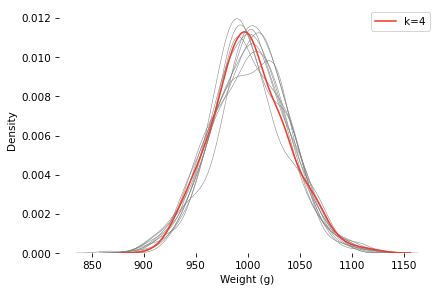

In [9]:
for i in range(10):
    sample = generate_sample(mean, std, k=1, n=365)
    sns.kdeplot(sample, color='gray', lw=0.5)

sns.kdeplot(sample4, color='C3', label='k=4')
decorate(xlabel='Weight (g)')
plt.savefig('bread_dist_compare.png', dpi=300)

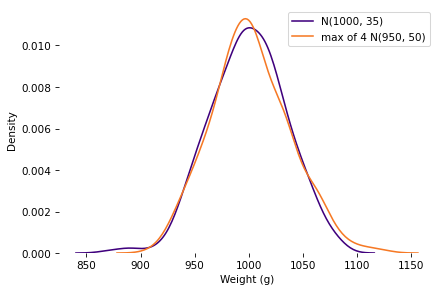

In [28]:
np.random.seed(19)

sample = generate_sample(mean, std, k=1, n=365)
sns.kdeplot(sample, color='C4', label='N(1000, 35)')

sns.kdeplot(sample4, color='C1', label='max of 4 N(950, 50)')
decorate(xlabel='Weight (g)')
plt.savefig('bread_dist_compare.png', dpi=300)

The `k=4` distribution falls mostly within the range of variation we'd expect from the `k=1` distribution with the same mean and standard deviation.
If you were on the jury and saw this evidence, would you convict the baker?

## Ask a Bayesian

As a Bayesian approach to this problem, let's see if we can use this data to estimate `k` and the parameters of the underlying distribution.
To compute the likelihood of the data, we have to do a little math.

Assume that $m$ is the maximum of $k$ draws from a distribution with CDF $F(x)$.
In general, the CDF of $m$ is

$$ F_M(m) = F(m)^k $$

which we can differentiate to get the PDF:

$$ f_M(m) = k f(m) F(m)^{k-1}  $$

If the draws are from a normal distribution with parameters $\mu$ and $\sigma$,

$$ F(m) = \Phi(z) $$

$$ f(m) = \frac{1}{\sigma} \phi(z) $$

where $\phi$ and $\Phi$ are the standard normal PDF and CDF, and $z$ is the standardized value $(m-\mu) / \sigma$. Plugging in, we get the PDF of $m$:

$$ f_M(m) = \frac{k}{\sigma} \phi(z) \Phi(z)^{k-1} $$

Here's a function that evaluates the log of this PDF at $m$.

In [10]:
LOG2PI = np.log(2 * np.pi)
SQRT2 = np.sqrt(2)

def max_normal_logp(m, mu, sigma, k):
    """Evaluate the log PDF of the distribution of the max of k draws."""
    z = (m - mu) / sigma
    log_phi = -0.5 * (z**2 + LOG2PI)

    # Use PyTensor's erfc for better numerical stability
    # Φ(z) = 0.5 * erfc(-z/√2)
    Phi = 0.5 * pm.math.erfc(-z / SQRT2)
    log_Phi = pm.math.log(Phi)
    
    return pm.math.log(k/sigma) + log_phi + (k - 1) * log_Phi

Now here's a PyMC model that 

* Defines prior distributions for `mu`, `sigma`, and `k`, and 

* Uses the previous function to define a custom distribution that computes the likelihood of the data for a hypothetical set of parameters.



In [11]:
def make_model(sample):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=950, sigma=30)
        sigma = pm.HalfNormal("sigma", sigma=30)
        k = pm.Uniform("k", lower=0.5, upper=15)

        obs = pm.CustomDist(
            "obs",
            mu, sigma, k,
            logp=max_normal_logp,
            observed=sample,
        )
    return model

Notice that we treat `k` as continuous.
That's because continuous parameters are much easier to sample (and the log PDF function allows non-integer values of `k`). 
But it also make sense in the context of the problem -- for example, if the baker sometimes hefts three loaves and sometimes four, we can approximate the distribution of the maximum with `k=3.5`.

Now let's sample.

In [12]:
model = make_model(sample4)
with model:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, k]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


The model runs quickly and the diagnostics look good.

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,940.810,21.048,900.642,979.223,0.840,0.517,626.0,792.0,1.0
sigma,53.525,5.706,42.235,63.465,0.223,0.135,658.0,800.0,1.0
k,5.264,2.526,1.462,9.986,0.101,0.088,629.0,776.0,1.0


Here are the posterior distributions of the parameters compared to their known values.

In [14]:
from scipy.stats import gaussian_kde

def plot_posterior(trace, var_name, x_true, xlabel='Weight (g)'):
    # Extract posterior samples
    samples = az.extract(trace)[var_name].to_numpy()
    mean = samples.mean()

    # KDE over posterior samples
    kde = gaussian_kde(samples)

    # Define range for plotting
    qs = np.linspace(samples.min(), samples.max(), 200)
    ps = kde(qs)

    # Evaluate posterior density at the true value
    p_true = kde(x_true)

    # Plot the KDE
    az.plot_posterior(trace, var_names=var_name, hdi_prob='hide')

    # Plot vertical lines at true value and mean
    plt.vlines(x_true, 0, p_true * 0.5, ls=':', color='gray')
    plt.vlines(mean, 0, p_true * 0.85, ls=':', color='gray')
    plt.text(x_true, p_true * 0.5, f'actual={x_true}', ha='right', fontsize=16)
    decorate(xlabel=xlabel)

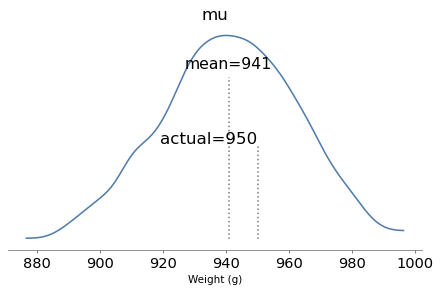

In [15]:
plot_posterior(trace, 'mu', mu_true)
plt.savefig('bread_posterior_mu.png', dpi=300)

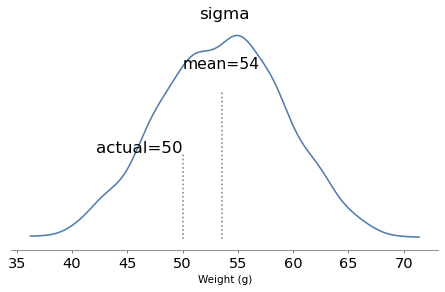

In [16]:
plot_posterior(trace, 'sigma', sigma_true)
plt.savefig('bread_posterior_sigma.png', dpi=300)

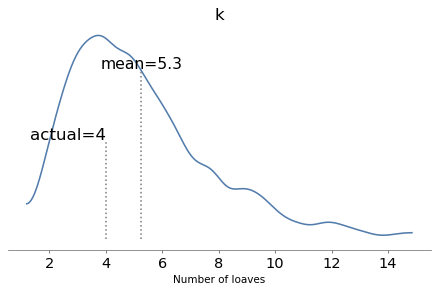

In [17]:
plot_posterior(trace, 'k', k_true, xlabel='Number of loaves')
plt.savefig('bread_posterior_k.png', dpi=300)

With one year of data, we can recover the parameters pretty well.
The true values fall comfortably inside the posterior distributions, and the posterior mode of `k` is close to the true value, `4`.

But the posterior distributions are still quite wide.
There is even some possibility that the baker is innocent, although it is small.

In [18]:
samples_k = az.extract(trace)['k'].to_numpy()
(samples_k < 1.5).mean()

0.00625

This example shows that we can use the shape of an observed distribution to estimate the effect of selection bias and recover the unbiased latent distribution.
But we might need a lot of data, and the inference depends on strong assumptions about the data generating process.

Credits: I don't remember where I got this example from (maybe [here](https://everything2.com/title/%2522true%2522+story+about+Poincar%25C3%25A9%2527s+baker)?), but it appears in Leonard Mlodinov, *The Drunkard's Walk* (2008). Mlodinov credits Bart Holland, *What Are the Chances?* (2002).
The [ultimate source](https://hsm.stackexchange.com/questions/7299/poincar%C3%A9-and-the-baker-was-the-anecdote-true) seems to be George Gamow and Marvin Stern, *Puzzle Math* (1958) -- but their version is about a German professor, not Poincaré.

1000.6543865551631

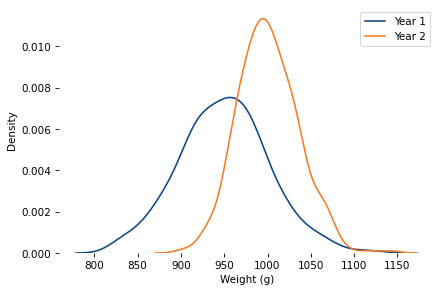

In [24]:
mu_true, sigma_true = 950, 50

sample2 = generate_sample(mu_true, sigma_true, k=4, n=365)

sns.kdeplot(sample, label=f'Year 1')
sns.kdeplot(sample2, label=f'Year 2')
    
decorate(xlabel='Weight (g)')
plt.savefig('bread_dist_2.png', dpi=300)
sample2.mean()

949.81307056437

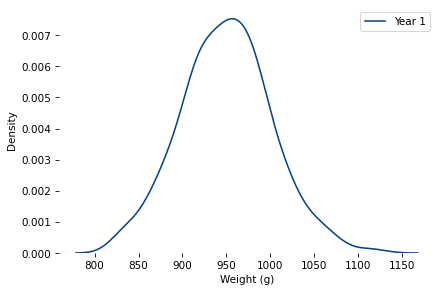

In [23]:
mu_true, sigma_true = 950, 50

sample = generate_sample(mu_true, sigma_true, k=1, n=365)
sns.kdeplot(sample, label=f'Year 1')
    
decorate(xlabel='Weight (g)')
plt.savefig('bread_dist_1.png', dpi=300)
sample.mean()

*Think Bayes*, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)